In [1]:
Threads.nthreads()

8

## Max-Sum

In [1]:
include("../code/rs_gfq.jl")
ProgressMeter.ijulia_behavior(:clear)

false

In [5]:
function rand_msg(Q::Int, noise::Real)
    v = SVector{Q}(noise*randn(Q))
    v .- maximum(v)
end
function rand_msg2(Q::Int, J::Int)
    @assert Q==2
    j = float(rand(-J:J)) 
    m = SVector{2}(0, j)
    m .- maximum(m)
end
function rand_msgQ(Q::Int, J::Int)
    js = float.(rand(-J:J,Q-1))
    js = [0.0; js]
    m = SVector{Q}(js)
    m .- maximum(m)
end   

rand_msgQ (generic function with 1 method)

In [11]:
Q = 2
gfmult, gfdiv = gftables(Val(Q))
N = 10^4
maxiter = 100
nsamples = 10
Λ = [0,1]; maxd = findlast(!iszero, Λ)
Pk = [0,0.7,0.3]; maxk = findlast(!iszero, Pk)
mK = sum(k*Pk[k] for k=eachindex(Pk)); mΛ = sum(d*Λ[d] for d=eachindex(Λ))
popP = [rand_msgQ(Q, maxk+1) for _ in 1:N]
popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
R = 1-mΛ/mK

0.13043478260869557

In [12]:
# errs = fill(NaN, maxiter)
# callback(it, err) = (errs[it]=err; nothing)
# Fs = fill(NaN, nsamples)
# # callback_fe(t, F, f) = (Fs[t] = F; nothing)
# cb_fe(F) = (Fs .= F)

In [13]:
tol = 1e-7
RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, toliter=tol, showprogress=true)

0.01089999999999991

In [14]:
f = zeros(nsamples)
for j in 1:nsamples
    RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, toliter=tol, showprogress=true)
    f[j] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, nsamples=100*N, showprogress=true)
end
D = mean(f)

0.3297286478260871

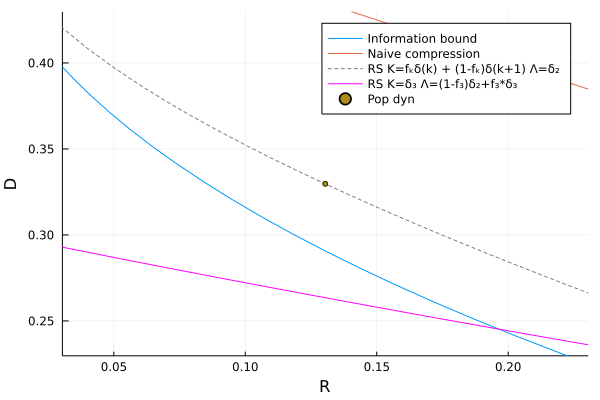

In [15]:
p1 = plot_rdb()
scatter!(p1, [R], [D], label="Pop dyn", ms=3)
xlims!(p1, (max(0,R-0.1),R+0.1)); ylims!(p1, (D-0.1,D+0.1))
# p2 = plot(1:maxiter, errs, label="error", yaxis=:log10)
# hline!(p2, [tol], label="tol")
# plot(p1,p2, size=(900,300), margin=5Plots.mm)

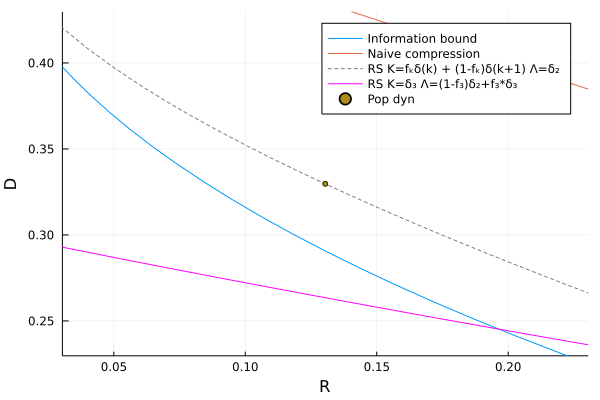

In [16]:
plot_rdb()
scatter!(R*ones(nsamples), f, label="Pop dyn", ms=3)
xlims!(p1, (max(0,R-0.1),R+0.1)); ylims!(p1, (D-0.1,D+0.1))

### Monitor the distortion

In [190]:
Q = 2
gfmult, gfdiv = gftables(Val(Q))
N = 10^5
Λ = [0,1]; maxd = findlast(!iszero, Λ)
Pk = [0,0.5,0.5]; maxk = findlast(!iszero, Pk)
mK = sum(k*Pk[k] for k=eachindex(Pk)); mΛ = sum(d*Λ[d] for d=eachindex(Λ))
R=1-mΛ/mK
popP = [rand_msgQ(Q, maxk+1) for _ in 1:N]
popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]

maxiter = 1
M = 50
errs = fill(NaN, M+1); 
ds = fill(NaN, M+1); ds[1] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=N, showprogress=false)
X = maxiter * (0:M)
Pfield = fill(zeros(N), M+1); Pfield[1] = [(p[1]-p[2]) for p in popP]
Qfield = fill(zeros(N), M+1); Qfield[1] = [(p[1]-p[2]) for p in popQ];

In [191]:
@showprogress for j in 1:M
    errs[j+1] = RS_gfq!(popP, popQ, Λ, Pk, Q, gfmult, gfdiv, maxiter=maxiter, showprogress=false)
    ds[j+1] = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=N, showprogress=false)
    Pfield[j+1] .= [(p[1]-p[2]) for p in popP]
    Qfield[j+1] .= [(p[1]-p[2]) for p in popQ]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


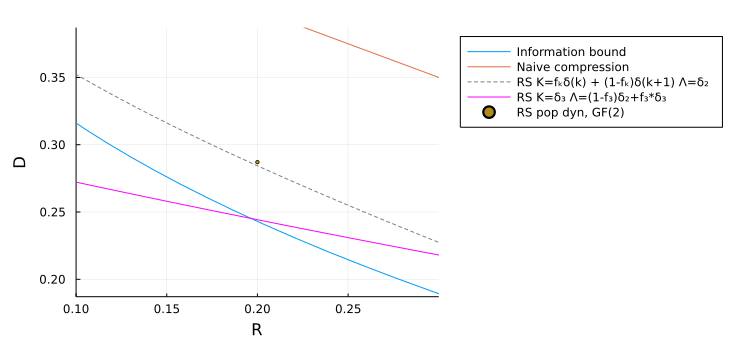

In [195]:
plot_rdb()
d = ds[end]
# d = median(ds)
# d = freenrj(Λ, Pk, Q, popP, popQ, gfmult, gfdiv, samples=10^5, showprogress=false)
# d = ds[argmin(errs)]
scatter!([R], [d], label="RS pop dyn, GF($Q)", ms=2, size=(750,350), 
    legend=:outertopright, margin=5Plots.mm)
xlims!((max(0,R-0.1),R+0.1)); ylims!(d-0.1,d+0.1)

┌ Info: Saved animation to 
│   fn = /home/crotti/sourcecoding/notebooks/tmp.gif
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/crotti/sourcecoding/notebooks/tmp.gif")
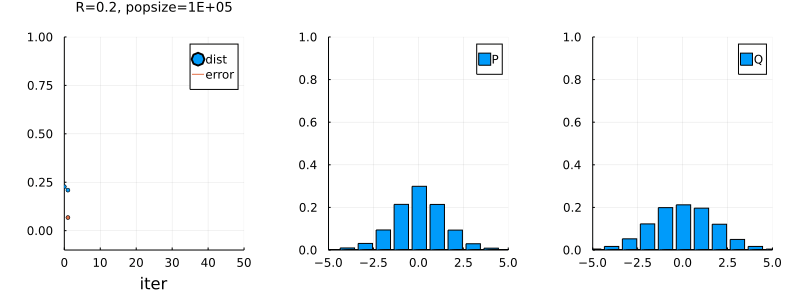

In [196]:
anim = @animate for j in 2:M
    p1 = plot(X[1:j], ds[1:j], label="dist", xlabel="iter", m=:o, size=(400,200),ms=2)
    title!(p1, "R=$(round(R,digits=3)), popsize="*(@sprintf("%.0E", N)), titlefontsize=9)
    xlims!(p1, extrema(X)); ylims!(p1, (-0.1,1))
    j !=1 && plot!(p1, X[1:j], errs[1:j], label="error", xlabel="iter", m=:o, ms=2)
    p2 = histogram(Pfield[j], normalize=:probability, label="P", barwidths=.8, xlims=(-5,5), ylims=(0,1))
    p3 = histogram(Qfield[j], normalize=:probability, label="Q", barwidths=.8, xlims=(-5,5), ylims=(0,1))
    plot(p1,p2,p3, layout=(1,3), size=(800,300), margin=5Plots.mm)
#     p4 = plot(X[1:j], errs[1:j], label="error", xlabel="iter", m=:o, ms=2, yaxis=:log10)
#     yl = extrema(errs)
#     xlims!(p4, extrema(X)); ylims!(p4, yl)
#     plot(p1,p4)
end
gif(anim, "/home/crotti/sourcecoding/notebooks/tmp.gif", fps=10)

## Varying rate

In [1]:
include("../code/rs_gfq.jl")
include("../../telegram/notifications.jl")
ProgressMeter.ijulia_behavior(:append)
using Base.Threads

In [6]:
Rs = 0.01:0.04:0.99
Qs = collect(2 .^ (1:2:7))
Qs = [4]
dist = [zeros(length(Rs)) for q in Qs]
# errs = zeros(length(Rs))
Λ = [0,1]
N = 10^4
maxiter = 100
nsamples = 10
@telegram "GF(q) RS" for (q,Q) in enumerate(Qs)
    mult, gfdiv = gftables(Val(Q))
    @showprogress for (i,r) in enumerate(Rs)
        α=1-r
        k=floor(Int, 2/α)
        s=k+1-2/α
        Pk=[fill(0,k-1); s; 1-s]
        Pk .*= Pk .> 1e-10
        Pk ./= sum(Pk)
        maxk = findlast(!iszero, Pk); maxd = findlast(!iszero, Λ)
        popP = [rand_msgQ(Q, maxk+1) for _ in 1:N]
        popQ = [rand_msgQ(Q, maxk+1) for _ in 1:N]
        F = zeros(nsamples)
        err = RS_gfq!(popP, popQ, Λ, Pk, Q, mult, gfdiv, maxiter=maxiter, showprogress=false)
        for j in 1:nsamples
            RS_gfq!(popP, popQ, Λ, Pk, Q, mult, gfdiv, maxiter=10, showprogress=false)
            F[j] = freenrj(Λ, Pk, Q, popP, popQ, mult, gfdiv, nsamples=100*N, showprogress=false)
        end
        dist[q][i] = mean(F[end:end])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:40:52


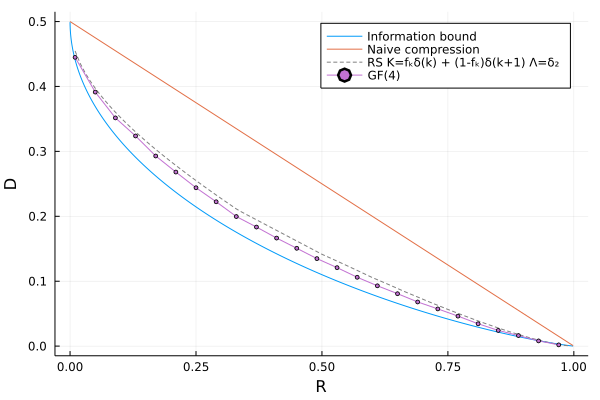

In [7]:
p = plot_rdb()
for (q,Q) in enumerate(Qs)
    plot!(p, Rs, dist[q], label="GF($Q)", m=:o, ms=2)
end
p
# savefig(plot(p, dpi=300), "gf32")

In [8]:
using DelimitedFiles
writedlm("gf4.txt", [Rs dist[1]])